# CNN with CAVI
## CNN model

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.log_softmax(x, dim=1)
        return output

model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1000, shuffle=True)


### Train the model

In [2]:
# Define a function for training the model
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Define a function for evaluating the model
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model for 10 epochs
for epoch in range(10):
    train(model, trainloader, criterion, optimizer, device)
    accuracy = evaluate(model, testloader, device)
    print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')


/home/jack/venv/lib/python3.12/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Accuracy: 98.28%
Epoch 2, Accuracy: 98.82%
Epoch 3, Accuracy: 98.74%
Epoch 4, Accuracy: 98.98%
Epoch 5, Accuracy: 98.82%
Epoch 6, Accuracy: 99.06%
Epoch 7, Accuracy: 99.13%
Epoch 8, Accuracy: 99.18%
Epoch 9, Accuracy: 99.06%
Epoch 10, Accuracy: 99.25%


## Save/load the model

In [119]:
# save the mode weights in .pth format (99.25% accuracy
# torch.save(model.state_dict(), 'CNN_MNSIT.pth')

# load the model weights
model.load_state_dict(torch.load('CNN_MNSIT.pth'))

/tmp/ipykernel_44324/525000725.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_MNSIT.pth'))


<All keys matched successfully>

/home/jack/venv/lib/python3.12/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


True y = 2, the probability: 1.00000
pixel from 2.821486711502075 to -0.4242129623889923


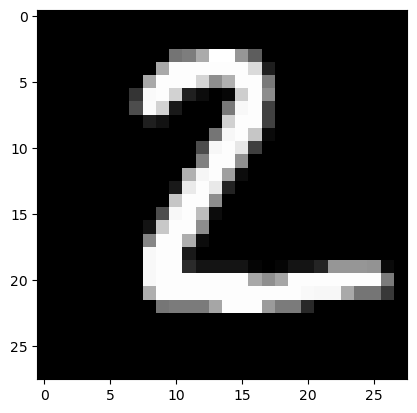

In [120]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
img_id =1
input = testset[img_id]
img = input[0].squeeze(0).clone()
plt.imshow(img,cmap='gray')
print(f'True y = {input[1]}, the probability: {F.softmax(model(input[0].unsqueeze(0)), dim=1).max():.5f}')
print(f'pixel from {img.max()} to {img.min()}')

The probability: 0.99972


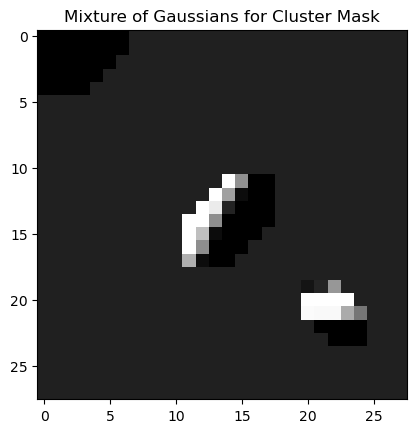

In [163]:
import numpy as np
import matplotlib.pyplot as plt

def cluster_mask(img, means, covs, threshold=0.1):
    # Generate a grid of points for the canvas
    x, y = np.mgrid[0:28, 0:28]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    # Calculate the probability density at each point on the grid for each component
    densities = []
    for mean, cov in zip(means, covs):
        z = np.exp(-0.5 * np.sum((pos - mean) @ np.linalg.inv(cov) * (pos - mean), axis=2))
        densities.append(z)

    # Create separate masks for each component
    masks = []
    for density in densities:
        mask = density < threshold
        masks.append(mask)

    # Combine the masks using logical operations
    mask = np.stack(masks, axis=2)
    mask = np.all(mask, axis=2)

    # Create a mask where the density is above the threshold
    indeces_1 = np.where(mask)
    # img[indeces_1] = np.random.rand(*indeces_1[0].shape)
    img[indeces_1] = 0

    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation 
    with torch.no_grad():
        new_img = torch.tensor(img).view(1, 1, 28, 28)
        probability = F.softmax(model(new_img), dim=1).max().item()
        print(f'The probability: {probability:.5f}')


    # model.eavl()
    # new_img = torch.tensor(img).view(1, 1, 28, 28)
    # print(f'True y = {input[1]}, the probability: {F.softmax(model(new_img), dim=1).max():.5f}')
    # Plot the masks using the modified image
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Mixture of Gaussians for Cluster Mask")
    plt.show()
    return img, mask

# Define the mean and covariance matrix for the multivariate normal distribution
mean = [[1, 1], [14, 14], [21, 22]]  # Center of the oval
cov = [[[10, -3], [-3, 20]], [[10, -5], [-5, 10]], [[5, 3], [3, 5]]]  # Covariance matrix (adjust for elliptical shape)

# TODO: change the threshold value
new_img, mask = cluster_mask(img.clone().numpy(), mean, cov, threshold=.5)



In [168]:
def compute_elbo(data, psi, m, s2, sigma2, mu0,input):
    """ Computes the ELBO. The elbo terms are numbered elbo_i where i corresponds to the term number 
    in the report.
    
    Parameters
    ----------
    data : numpy.ndarray
        The data, of shape (n, dim)
    psi : numpy.ndarray
        Parameters of categorical posterior over mixture assignment.
        Of shape (n, k).
        Conjugate prior is Diriclet.
        np.sum(psi, axis=1) is all ones
    m : numpy.ndarray
        Mean parameters of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, p) where p is the dimesionality of the data.
        Conjugate prior is Gaussian.
    s2 : numpy.ndarray
        Variance (std squared) of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, 1) since clusters have diagonal covariance matrix, i.e.: all have same variance.
    sigma2 : numpy.ndarray
        Variance of the Gaussian of the prior mean per cluster.
        Of shape (), since it is a float
    m0 : numpy.ndarray
        Mean of the Gaussian of the prior mean per cluster.
        Of shape (p, ) where p is the dimensioanlity of the data.
        
    Returns
    -------
    elbo : float
        ELBO.
    """
    n, p = data.shape
    k = m.shape[0]

    elbo = 0

    # TODO: compute ELBO
    # expected log prior over mixture assignments
    elbo_2 = - n * np.log(k)

    # expected log prior over mixture locations
    elbo_1 = \
        -0.5 * (p * k * np.log(2*np.pi * sigma2))
    
    elbo_1_intermediate = 0
    
    for k_idx in range(k):
        elbo_1_intermediate += \
            p * s2[k_idx] + np.dot(m[k_idx].T, m[k_idx]) \
            - np.dot(m[k_idx].T, mu0) \
            - np.dot(mu0.T, m[k_idx]) \
            - np.dot(mu0.T, mu0)
    
    # -0.5 or +0.5?
    elbo_1 += -0.5 * sigma2**(-1) * elbo_1_intermediate
    
    # expected log likelihood
    
    # for diagonal covariance, lambda is set to 1
    lambda_ = 1.0
    
    elbo_3 = 0
    
    for n_idx in range(n):
        for k_idx in range(k):
            elbo_3 += \
                psi[n_idx, k_idx] * \
                (
                    -0.5 * p * np.log(2*np.pi*lambda_**2) \
                    -0.5 * lambda_**(-2) * \
                    (
                        np.dot(data[n_idx,:].T, data[n_idx,:]) \
                        - np.dot(data[n_idx,:].T, m[k_idx]) \
                        - np.dot(m[k_idx].T, data[n_idx,:]) \
                        + s2[k_idx] * p \
                        + np.dot(m[k_idx].T, m[k_idx])
                    ) 
                )

    # entropy of variational location posterior
    
    elbo_4 = 0
    
    for k_idx in range(k):
        elbo_4 += np.log(2*np.pi) + 2 * np.log(s2[k_idx]) + 1

    # entropy of the variational assignment posterior
    
    elbo_5 = 0
    
    for n_idx in range(n):
        for k_idx in range(k):
            elbo_5 -= psi[n_idx, k_idx] * np.log(psi[n_idx, k_idx])
    
    # Set the model to evaluation mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
        input = torch.tensor(data).view(n, 1, 28, 28)
        elbo_model = np.log(F.softmax(model(input)) )
    # sum up elbo
    elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5 + elbo_model
    
    return elbo

In [ ]:

def cavi(data, k, sigma2, m0, eps=1e-15):
    """ Coordinate ascent Variational Inference for Bayesian Mixture of Gaussians
    
    Parameters
    ----------
    data : numpy.ndarray
        The data, of shape (n, dim)
    k : int
        Number of clusters.
    sigma2 : numpy.ndarray
        Variance of the Gaussian of the prior mean per cluster.
        Of shape (), since it is a float
    m0 : numpy.ndarray
        Mean of the Gaussian of the prior mean per cluster.
        Of shape (p, ) where p is the dimensioanlity of the data.
    eps : float
        Convergence criterion.
        
    Returns
    -------
    m : numpy.ndarray
        Mean parameters of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, p) where p is the dimesionality of the data.
        Conjugate prior is Gaussian.
    s2 : numpy.ndarray
        Variance (std squared) of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, 1) since clusters have diagonal covariance matrix, i.e.: all have same variance.
    psi : numpy.ndarray
        Parameters of categorical posterior over mixture assignment.
        Of shape (n, k).
        Conjugate prior is Diriclet.
        np.sum(psi, axis=1) is all ones
    elbo : float
        ELBO.
    """
    n, p = data.shape
    # initialize randomly
    m = np.random.normal(0., 1., size=(k, p))
    s2 = np.square(np.random.normal(0., 1., size=(k, 1)))
    psi = np.random.dirichlet(np.ones(k), size=n)

    # compute ELBO
    elbo = [compute_elbo(data, psi, m, s2, sigma2, m0)]
    convergence = 1.
    # for diagonal covariance, lambda is set to 1
    lambda_ = 1.0
    
    while convergence > eps:  # while ELBO not converged
        
        # update categorical
        for n_idx in range(n):
            for k_idx in range(k):
                psi[n_idx, k_idx] = \
                    np.exp(
                        np.dot(data[n_idx].T, m[k_idx]) * lambda_**(-2) \
                        - 0.5 * lambda_**(-2) * (np.dot(m[k_idx].T, m[k_idx]) + p*s2[k_idx])
                    )
            psi[n_idx] /= np.sum(psi[n_idx])
        
        # update posterior parameters for the component means
        for k_idx in range(k):
            for n_idx in range(n):
                s2[k_idx] += lambda_**(-2) * psi[n_idx, k_idx]
            
            s2[k_idx] += sigma2**(-2)
            s2[k_idx] = s2[k_idx]**(-1)
        
        for k_idx in range(k):
            for n_idx in range(n):
                m[k_idx] += psi[n_idx, k_idx] * data[n_idx]
            m[k_idx] *= lambda_**(-2)
            m[k_idx] += m0 / sigma2
            m[k_idx] *= s2[k_idx]
        
        # compute ELBO
        elbo.append(compute_elbo(data, psi, m, s2, sigma2, m0))
        convergence = elbo[-1] - elbo[-2]

    return m, s2, psi, elbo

In [164]:
np.where(mask == 0)


(array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4, 11, 11, 11, 11, 12,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
        15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 19, 19,
        19, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  0,  1,  2,  3,  4,  5,  6,  0,  1,  2,
         3,  4,  5,  0,  1,  2,  3,  4,  0,  1,  2,  3, 14, 15, 16, 17, 13,
        14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 11, 12, 13, 14, 15, 16, 17,
        11, 12, 13, 14, 15, 16, 11, 12, 13, 14, 15, 11, 12, 13, 14, 20, 21,
        22, 20, 21, 22, 23, 20, 21, 22, 23, 24, 21, 22, 23, 24, 22, 23, 24]))

In [ ]:
class MGMM(object):
    """Multivariate GMM with CAVI"""

    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.D = self.X.shape[1]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet(
            [np.random.random() * np.random.randint(1, 10)] * self.K, self.N
        )
        self.m = np.random.randint(
            int(self.X.min()), high=int(self.X.max()), size=(self.K, self.D)
        ).astype(float)
        self.s2 = np.ones((self.K, self.D)) * np.random.random((self.K, self.D))
        print("Init mean")
        print(self.m)
        print("Init s2")
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m / self.sigma2
        t1 = t1.sum()
        t2 = -0.5 * np.add.outer(np.sum(self.X**2, axis=1), np.sum(self.s2 + self.m**2, axis=1))
        t2 += np.dot(self.X, self.m.T)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter + 1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print(
                    "ELBO converged with ll %.3f at iteration %d"
                    % (self.elbo_values[-1], iter_)
                )
                break

        if iter_ == max_iter:
            print("ELBO ended with ll %.3f" % (self.elbo_values[-1]))

    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.dot(self.X, self.m.T)
        t2 = -(0.5 * np.sum(self.m**2 + self.s2, axis=1))
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = np.dot(self.phi.T, self.X) * (
            1 / self.sigma2 + np.sum(self.phi, axis=0)
        ) ** (-1)
        assert self.m.shape == (self.K, self.D)
        self.s2 = (1 / self.sigma2 + np.sum(self.phi, axis=0)) ** (-1)
        assert self.s2.shape == (self.K, self.D)